# Product Demand Forecast

In [1]:
import pandas as pd
import numpy as np

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import OneHotEncoder
import joblib

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL, seasonal_decompose

from tbats import TBATS, BATS

from xgboost import XGBRegressor

from itertools import product 
from ast import literal_eval

from time import time
from datetime import timedelta
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar

from multiprocessing import Pool
import functools

from pathlib import Path

from tqdm.notebook import tqdm
import warnings

C:\Users\ASUS\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def print_elapsed_time(start):
    elapsed = timedelta(seconds=time() - start)
    # remove millis
    elapsed = str(elapsed).split('.')[0]
    print('Elapsed time: {}'.format(elapsed))


def get_timestamp_string(ts, ts_format='%Y-%m-%d %H:%M:%S'):
    return datetime.fromtimestamp(start_time).strftime(ts_format)


def calc_datetime_delta(d1, d2, date_format='%Y-%m-%d'):
    d1 = datetime.strptime(d1, date_format)
    d2 = datetime.strptime(d2, date_format)
    delta = d2 - d1
    return delta.days

In [3]:
PROCESS_COUNT = 1

## Explore data

### Read input data

In [4]:
orig_train_df = pd.read_csv('dataset/demand-forecasting-kernels-only/train.csv')
print('Original: ' + str(orig_train_df.shape))
orig_train_df

Original: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


### Data preprocessing

Use more compact and consistent column names

In [5]:
train_df = orig_train_df.copy()
train_df.columns = ['date', 'store', 'item', 'sales']

Then, Let's check for NAs

In [6]:
train_df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

Make sure that we don't have any NAs in our dataset

In [7]:
# remove NA
train_df.dropna(inplace=True)
print('After: ' + str(train_df.shape))

After: (913000, 4)


In [8]:
# Remove redundant prefixes
# demand_df.ID = [cat.split('_')[1] for cat in demand_df.ID]
# demand_df.Category = [cat.split('_')[1] for cat in demand_df.Category]

convert the data to daily

In [9]:
def group_demand_by(df, columns):
    df = df.groupby(columns).sum()
    df = df.reset_index().sort_values(columns)
    return df

In [10]:
train_df.date = pd.to_datetime(train_df.date)
train_df = group_demand_by(train_df, ['date', 'item', 'store'])
train_df

,date,item,store,sales
0,2013-01-01,1,1,13
1,2013-01-01,1,2,12
2,2013-01-01,1,3,19
3,2013-01-01,1,4,10
4,2013-01-01,1,5,11
...,...,...,...,...
912995,2017-12-31,50,6,45
912996,2017-12-31,50,7,46
912997,2017-12-31,50,8,76
912998,2017-12-31,50,9,65


A little summary for our data

In [11]:
def get_date_range(df, debugging=False):
    dates = df.date if 'date' in df.columns else df.index
    date_range = (dates.min(), dates.max())
    if debugging:
        print('({} - {})'.format(*date_range))
    return date_range

In [12]:
print('Date range: ')
date_range = get_date_range(train_df, debugging=True)
train_df.drop('date', axis=1).describe(include='all').iloc[:4,:]

Date range: 
(2013-01-01 00:00:00 - 2017-12-31 00:00:00)


,item,store,sales
count,913000.000000,913000.000000,913000.000000
mean,25.500000,5.500000,52.250287
std,14.430878,2.872283,28.801144
min,1.000000,1.000000,0.000000


### Generic plots

In [13]:
sns.set(rc={'figure.figsize':(15, 8)})

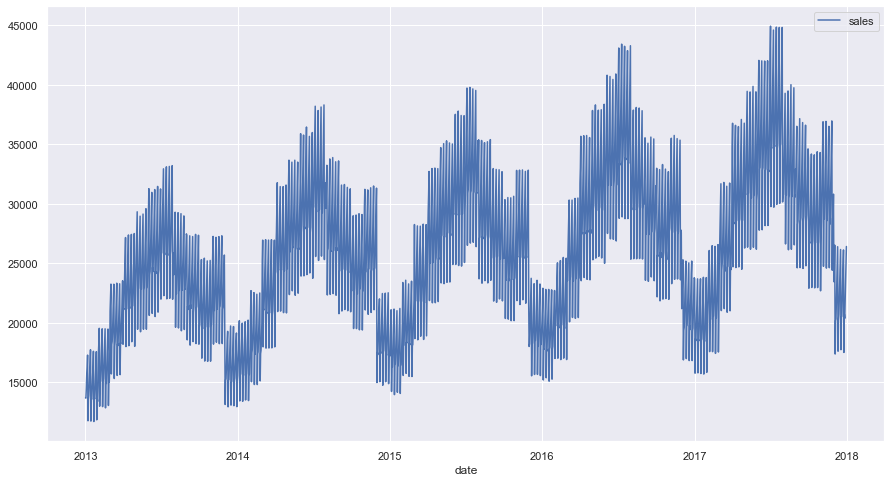

In [14]:
df = group_demand_by(train_df, ['date'])
df = df.drop(columns=['item', 'store']).set_index('date')
g = sns.lineplot(data=df)
g.get_figure().savefig('plots/generic.jpg')
del g

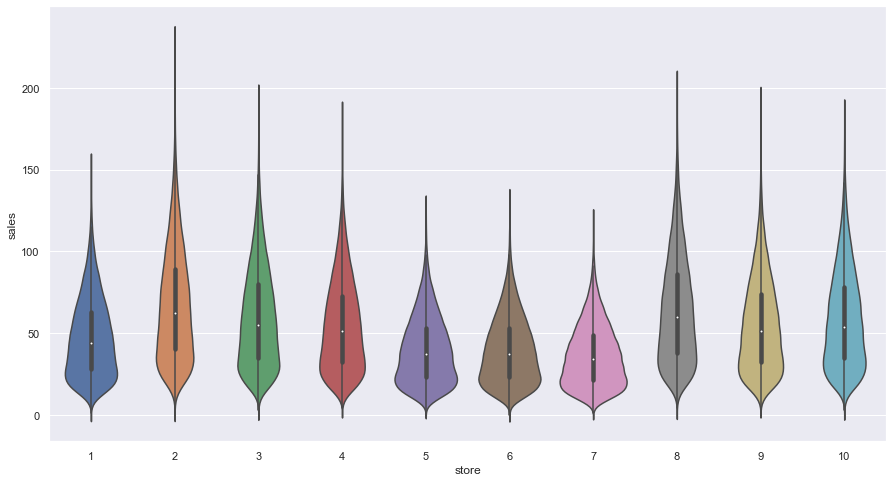

In [15]:
sns.violinplot(data=train_df, y='sales', x='store')

In [16]:
def plot_stl(df, plot_orig=False, plot_trend=True, plot_seasonal=True, plot_residual=True):
    sns.set(rc={'figure.figsize':(15, 4)})
    
    stl = STL(df)
    result = stl.fit()

    seasonal, trend, resid = result.seasonal, result.trend, result.resid

    fig = plt.figure(figsize=(15,8))

    if plot_orig:
        plt.subplot(4,1,1)
        plt.plot(df)
        plt.title('Original Series', fontsize=16)

    if plot_trend:
        plt.subplot(4,1,2)
        plt.plot(trend)
        plt.title('Trend', fontsize=16)

    if plot_seasonal:
        plt.subplot(4,1,3)
        plt.plot(seasonal)
        plt.title('Seasonal', fontsize=16)

    if plot_residual:
        plt.subplot(4,1,4)
        plt.plot(resid)
        plt.title('Residual', fontsize=16)

    plt.tight_layout()
    fig.savefig('plots/stl.jpg')

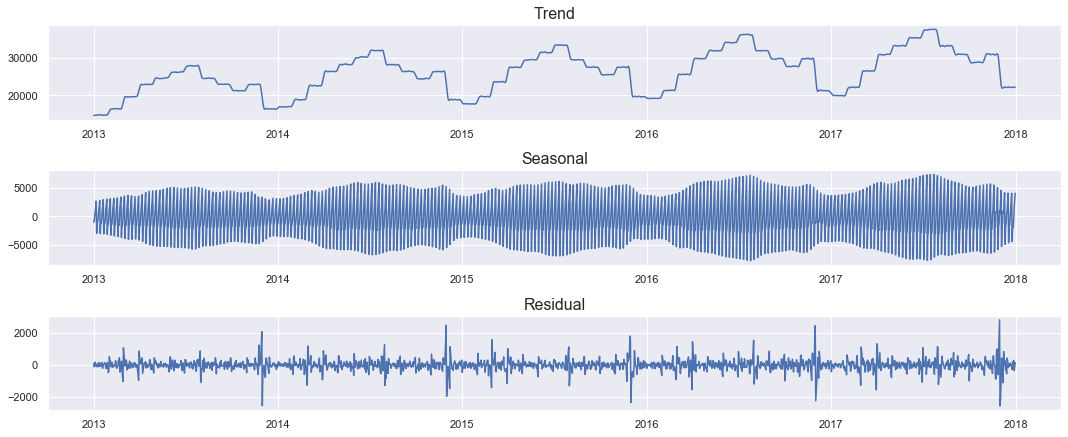

In [17]:
plot_stl(df)

### Read test set

In [18]:
test_df = pd.read_csv('dataset/demand-forecasting-kernels-only/test.csv', index_col='id')
test_df.date = pd.to_datetime(test_df.date)
test_df

,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1
...,...,...,...
44995,2018-03-27,10,50
44996,2018-03-28,10,50
44997,2018-03-29,10,50


## Exploratory time-series analysis

### Stationarity check

In [19]:
# simple function to filter dataframe with given parameters
def filter_demand(df, item=None, store=None, category=None, sales=-1):
    df = df.copy()
    if item is not None:
        df = df[df.item == item]
    if store is not None:
        df = df[df.store == store]
    if category is not None:
        df = df[df.category == category]
    if sales > -1:
        df = df[df.sales > sales]
    return df

In [20]:
def is_stationary(df, print_stats=False):
    result = adfuller(df)
    if print_stats:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
    return result[1] < 0.001

Check stationarity of 100 items with highest frequency

In [21]:
non_stationary = []
stationary_check = False

if stationary_check:
    n = 100
    check_items = train_df.item.value_counts().index[:n]
    for item in tqdm(check_items):
        df = filter_demand(train_df, item=item).sales
        if not is_stationary(df):
            non_stationary.append(item)
    print('{}/{} are not stationary'.format(len(non_stationary), n))

All of them is already stationary. However, let's still write a simple function to apply differencing, in case we want to test with other datasets.

In [22]:
import warnings
def apply_differencing(df, periods=1, ffill=False, stationary_check=True):
    if isinstance(df, pd.DataFrame) and 'sales' in df.columns:
        df.sales = df.sales.diff(periods=periods)
    else:
        df = df.diff(periods=periods)
    df = df.ffill() if ffill else df.dropna()
        
    if stationary_check and not is_stationary(df.sales if isinstance(df, pd.DataFrame) else df):
        warnings.warn('DataFrame is still not stationary.')
    return df

In [23]:
if len(non_stationary) > 0:
    non_stationary = []
    for check_id in tqdm(check_ids):
        df = filter_demand(daily_demand_df, ID=str(check_id)).Demand
        if not is_stationary(apply_differencing(df)):
            non_stationary.append(check_id)
    print('{}/{} are not stationary'.format(len(non_stationary), n))

Okay, now we have the function, we only need to call it when we build the model.

## Finding correlation  

First, since we're dealing with one product at a time, we need a simple function to filter dataset based on the item ID. Since there might be some days with no demand for a particular product, we need to fill those missing dates with 0.

In [24]:
# a simple function to get appropriate training data
def get_train_data(df, date_range=None, differencing=0):
    # we don't need these columns now
    df = df.drop(columns=['store', 'item'])
    
    df = df.set_index('date')
    
    # fill date gap with 0
    if date_range is not None:
        idx = pd.date_range(*date_range)
        df = df.reindex(idx, fill_value=0)
        
    # apply diffencing of 0
    if differencing > 0:
        df = apply_differencing(df, periods=differencing)
    
    return df

Next, we need a specific product to find out the correlation

**Clarification**: Each product's demand might be completely different from each other, so the correlation of one product might not hold true to others, eventually produces inaccurate results. In this project, I will only consider products with high demand, e.g. staples, so there will be high chance that they have similar correlation.

In [25]:
# getting the item with highest demand
highest_freq_item = train_df.item.value_counts().index[0]
highest_freq_item_df = filter_demand(train_df, item=highest_freq_item, store=1)
train_date_range = get_date_range(train_df, debugging=True)
item_df = get_train_data(highest_freq_item_df, train_date_range)
item_diff_df = get_train_data(highest_freq_item_df, train_date_range, differencing=True)
del highest_freq_item_df

(2013-01-01 00:00:00 - 2017-12-31 00:00:00)


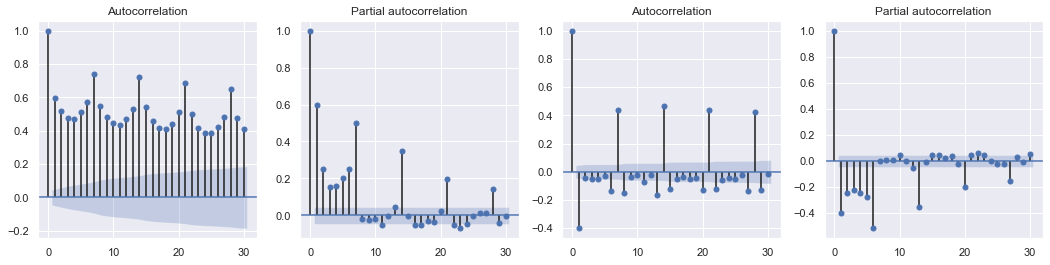

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(18,4))
lags = 30
g1 = sm.graphics.tsa.plot_acf(item_df, lags=lags, ax=ax[0], title='Autocorrelation')
g2 = sm.graphics.tsa.plot_pacf(item_df, lags=lags, ax=ax[1], title='Partial autocorrelation')
sm.graphics.tsa.plot_acf(item_diff_df, lags=lags, ax=ax[2], title='Autocorrelation')
sm.graphics.tsa.plot_pacf(item_diff_df, lags=lags, ax=ax[3], title='Partial autocorrelation')
fig.savefig('plots/ACF.jpg')

It is quite obvious that the item also has weekly seasonality.

In this project, I will use **_TBATS_**, a method specifically designed to handle datasets with multiple seasonalities. The traditional **_SARIMA_** model will also be conducted to compare the results. Apart from that, **_XGBoost_** will also be conducted.

## SARIMA

### Finding right parameters

In [27]:
def_range = range(0, 4)
def_s_range = (1, 2, 5, 7)
@ignore_warnings(category=ConvergenceWarning)
def optimize_SARIMA(df, p_range=def_range, d=1, q_range=def_range, P_range=def_range, D=1, 
                    Q_range=def_range, s_range=def_s_range, fourier=False, multiprocessing=False):   
    results = []
    best_aic = float('inf')

    def _get_sarima_param(param):
        order = (param[0], d, param[1])
        seasonal_order = (param[2], D, param[3], param[4])
        return [order, seasonal_order]

    params = list(product(p_range, q_range, P_range, Q_range, s_range))
    params = [_get_sarima_param(param) for param in params]
    
    exog_to_train, _ = _get_fourier_terms(df) if fourier else None

    results = []
    if multiprocessing:
        with Pool(PROCESS_COUNT) as pool:
            mp_param = functools.partial(test_model_sarima, df, exog=exog_to_train)
            results = list(tqdm(pool.imap(mp_param, params, chunksize=10), total=len(params)))
            results = [result for result in results if result is not None]
    else:
        for param in tqdm(params):
            result = test_model_sarima(df, param, exog_to_train)
            if result is not None:
                results.append(result)

    results = pd.DataFrame(results, columns=['param', 'aic']).sort_values('aic')    
    return results.reset_index(drop=True)

In [28]:
d = 1
D = 0

In [29]:
tried_params_filepath = "sarima_params.csv"
if Path(tried_params_filepath).is_file():
    print('Reading from {}...'.format(tried_params_filepath))
    tried_models = pd.read_csv(tried_params_filepath)
    tried_models.param = tried_models.param.apply(lambda param: literal_eval(param))
else:
    print('{} does not exist. Finding best SARIMA model...'.format(tried_params_filepath))
    tried_models = optimize_SARIMA(item_df, d=d, D=D)
    tried_models.to_csv(tried_params_filepath, index=False)

Reading from sarima_params.csv...


So, we have the right params for our SARIMA model now

In [30]:
print('Parameters of best SARIMA model:')
order, seasonal_order = tried_models.param[0]
sarima_param = {'order': order, 'seasonal_order': seasonal_order}
print(sarima_param)

Parameters of best SARIMA model:
{'order': (0, 1, 1), 'seasonal_order': (3, 0, 1, 7)}


### Generalized model

The function is written as a generalized model, so we only need to supply the model function, instead of rewriting for each of them.

In [31]:
def pred_demand_by(model_func, forecast_steps, train_inst_min, kwargs, param):
    warnings.simplefilter("ignore")
    # get train data
    item_train_df = filter_demand(train_df, item=param[1], store=param[0])
    if isinstance(train_inst_min, int) and len(item_train_df) < train_inst_min:
        return
    item_train_df = get_train_data(item_train_df, train_date_range)
    # train and predict
    pred = model_func(item_train_df, forecast_steps, kwargs)
    # print('{} {} {}'.format(*param, len(pred) if pred is not None else None))
    return [*param, pred]
        

def pred_demands(train_df, test_df, model_func, forecast_steps=196, train_inst_min=None, multiprocessing=False, kwargs={}):
    unique_items = test_df.item.unique()
    unique_stores = test_df.store.unique()
    combinations = list(product(test_df.store.unique(), test_df.item.unique()))

    if train_inst_min is None:
        train_inst_min = 0

    preds = []
    if multiprocessing:
        with Pool(PROCESS_COUNT) as p:
            mp_param = functools.partial(pred_demand_by, model_func, forecast_steps, train_inst_min, kwargs)
            preds = list(tqdm(p.imap(mp_param, combinations), total=len(combinations)))
    else:
        for combination in tqdm(combinations):
            pred = pred_demand_by(model_func, forecast_steps, train_inst_min, kwargs, combination)
            preds.append(pred)

    # convert to DataFrame
    for pred in preds:
        pred[2] = ' '.join(map(str, pred[2]))
    return pd.DataFrame(preds, columns=['store', 'item', 'pred'])

Simple function to plot both training data and prediction

In [32]:
def get_prediction_df(df, item, store):
    # raw prediction doesn't have dates, so we need to figure it out
    pred_count = len(df.pred[0])
    pred_start_date = test_df.date[0]
    pred_end_date = pred_start_date + timedelta(days=pred_count - 1)
    pred_date_range = pd.date_range(pred_start_date, pred_end_date)
    # filter and insert dates
    df = filter_demand(df, store=store, item=item)
    df = pd.DataFrame(df.pred.values[0], columns=['pred'])
    df.index = pred_date_range
    
    return df

In [33]:
def plot_prediction(pred_df, item, store, method):
    # train data
    train_plot_df = filter_demand(train_df, item=item, store=store) \
                        .drop(columns=['item', 'store']) \
                        .set_index('date')
    train_plot_df = train_plot_df[train_plot_df.index > '01-01-2015']
    # prediction
    pred_plot_df = get_prediction_df(pred_df, item, store)
    # join and plot
    df = train_plot_df.join(pred_plot_df, how='outer')
    g = sns.lineplot(data=df)
    plt.title('Prediction for item {} of store {}'.format(item, store))
    g.get_figure().savefig('plots/{}_{}_{}.jpg'.format(method, item, store))

In [34]:
# for testing 
item = 9
store = 3

### Build SARIMA model

In [35]:
def model_sarima(df, steps, kwargs):
    exog_to_train, exog_to_test = None, None
    if 'fourier' in kwargs and kwargs['fourier']:
        exog_to_train, exog_to_test = _get_fourier_terms(df, steps)

    # train
    try: 
        model = SARIMAX(df, order=kwargs['order'], seasonal_order=kwargs['seasonal_order'], exog=exog_to_train)
        model = model.fit(disp=-1)
    except: return None
    # predict
    return model.forecast(steps, exog=exog_to_test).reset_index(drop=True)

In [36]:
sarima_pred_filepath = 'sarima_prediction.csv'
if Path(sarima_pred_filepath).is_file():
    print('Reading from {}...'.format(sarima_pred_filepath))
    pred_sarima = pd.read_csv(sarima_pred_filepath)
    pred_sarima.pred = pred_sarima.pred.apply(lambda pred: np.fromstring(pred, dtype=float, sep=' '))
else:
    print('{} does not exist. Running SARIMA...'.format(sarima_pred_filepath))
    pred_sarima = pred_demands(train_df, test_df, model_sarima, pred_count, kwargs=sarima_param)
    pred_sarima.to_csv(sarima_pred_filepath, index=False)

Reading from sarima_prediction.csv...


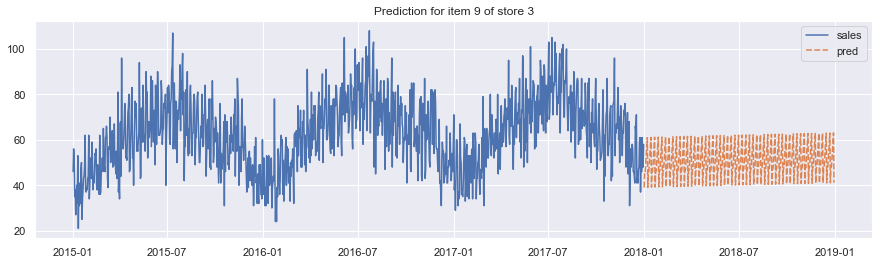

In [37]:
plot_prediction(pred_sarima, item=item, store=store, method='sarima')

Since SARIMA is not designed to handle multiple seasonality, it only captures the weekly seasonality, but completely ignore the yearly component. 

To compensate for this, we need to explicitly tell it the component by incorporating it as an exogenous variable.

### SARIMAX with Fourier terms
Again, we need to find the best parameters first

In [38]:
# SARIMA model with FOURIER
sarima_fourier_params_filepath = "sarima_fourier_params.csv"
if Path(sarima_fourier_params_filepath).is_file():
    print('Reading from {}...'.format(sarima_fourier_params_filepath))
    tried_models = pd.read_csv(sarima_fourier_params_filepath)
    tried_models.param = tried_models.param.apply(lambda param: literal_eval(param))
else:
    print('{} does not exist. Finding best SARIMA with FOURIER model...'.format(sarima_fourier_params_filepath))
    tried_models = optimize_SARIMA(item_df, d=d, D=D, fourier=True, multiprocessing=True)
    tried_models.to_csv(sarima_fourier_params_filepath, index=False)

Reading from sarima_fourier_params.csv...


In [39]:
print('Parameters of best SARIMA with FOURIER:')
order, seasonal_order = tried_models.param[0]
sarima_fourier_param = {'order': order, 'seasonal_order': seasonal_order}
print(sarima_fourier_param)

Parameters of best SARIMA with FOURIER:
{'order': (2, 1, 3), 'seasonal_order': (3, 0, 1, 7)}


Now we have obtained the best parameters for the SARIMAX model, we can build it now

In [40]:
sarima_fourier_pred_filepath = 'sarima_fourier_prediction.csv'
if Path(sarima_fourier_pred_filepath).is_file():
    print('Reading from {}...'.format(sarima_fourier_pred_filepath))
    pred_sarima_fourier = pd.read_csv(sarima_fourier_pred_filepath)
    pred_sarima_fourier.pred = pred_sarima_fourier.pred.apply(lambda pred: np.fromstring(pred, dtype=float, sep=' '))
else:
    print('{} does not exist. Running SARIMA with FOURIER...'.format(sarima_fourier_pred_filepath))
    # indicate Fourier transformation
    sarima_fourier_param = sarima_param.copy()
    sarima_fourier_param['fourier'] = True
    # train model
    pred_sarima_fourier = pred_demands(train_df, test_df, model_sarima, pred_count, kwargs=sarima_fourier_param)
    pred_sarima_fourier.to_csv(sarima_fourier_pred_filepath, index=False)

Reading from sarima_fourier_prediction.csv...


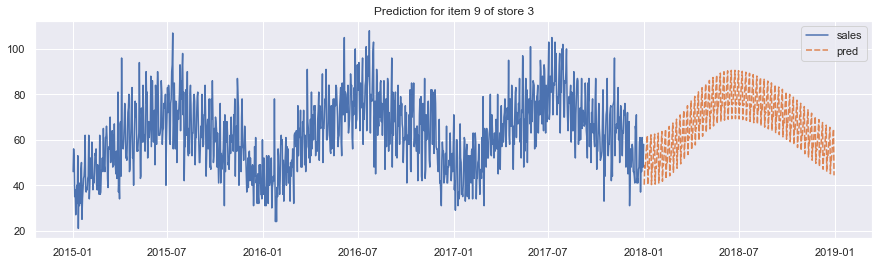

In [41]:
plot_prediction(pred_sarima_fourier, item=item, store=store, method='sarima_fourier')

With the Fourier term as the exogenous variable, the model is much better at capturing both seasonality. However, it apparently still couldn't fully capture the pattern. If we look at the training data, we could see a slight increase at around September period, but this is completely neglected by the model.

## TBATS

Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components.

In [42]:
def model_tbats(train_df, steps, kwargs):
    estimator = TBATS(seasonal_periods=(7, 365.25), n_jobs=1)
    model = estimator.fit(train_df)
    return model.forecast(steps=steps)

In [43]:
tbats_pred_filepath = 'tbats_prediction.csv'
if Path(tbats_pred_filepath).is_file():
    print('Reading from {}...'.format(tbats_pred_filepath))
    pred_tbats = pd.read_csv(tbats_pred_filepath)
    pred_tbats.pred = pred_tbats.pred.apply(lambda pred: np.fromstring(pred, dtype=float, sep=' '))
else:
    print('{} does not exist. Running TBATS...'.format(tbats_pred_filepath))
    # apparently, tbats already uses multiprocessing underneath
    pred_tbats = pred_demands(train_df, test_df, model_tbats, pred_count, multiprocessing=True) 
    pred_tbats.to_csv(tbats_pred_filepath, index=False)

Reading from tbats_prediction.csv...


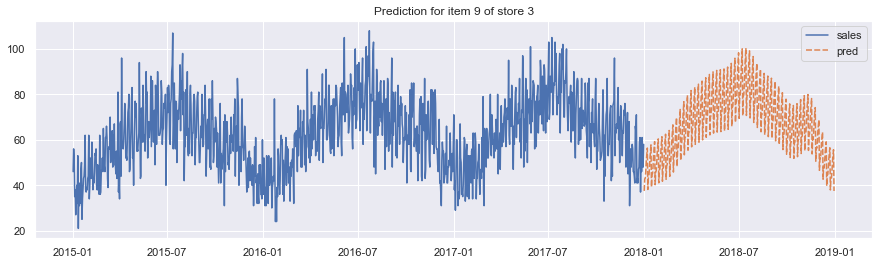

In [44]:
plot_prediction(pred_tbats, item=item, store=store, method='tbats')

## XGBoost

In [45]:
def _create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df


def _create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df


def add_new_features(df):
    if df.index.name != 'date':
        df = df.set_index('date')

    dates = df.index
    df['weekday'] = dates.dayofweek
    df['is_weekend'] = (df['weekday'] >= 4).astype(int)
    df['day'] = dates.day
    df['day_of_year'] = dates.dayofyear
    df['is_month_start'] = (dates.is_month_start).astype(int)
    df['is_month_end'] = (dates.is_month_end).astype(int)
    df['week_of_year'] = dates.isocalendar().week.astype(int)
    df['month'] = dates.month
    df['quarter'] = (df.month - 1) // 3
    df['year'] = dates.year

    # 12 month lag
    prior_year_sales = df.reset_index()[['date','sales','store','item']]
    prior_year_sales['date'] += pd.Timedelta('365 days')
    prior_year_sales.columns = ['date','12m_lag','store','item']
    df = df.merge(prior_year_sales, on=['date','store','item'])

    # is holiday or not
    holidays = USFederalHolidayCalendar().holidays(start=df.date.min(), end=df.date.max())
    df['holiday'] = df.date.isin(holidays).astype(int)
    
    df = _create_sales_lag_feats(df, gpby_cols=['store','item'], target_col='sales', 
                               lags=[91,98,105,112,119,126,182,364])

    df = _create_sales_ewm_feats(df, gpby_cols=['store','item'], 
                               target_col='sales', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[91,98,105,112,119,126,182,364,546,728])

    df = df.set_index('date')
    
    # convert categorical columns to numerics
    #num_cols = ['sales', '12m_lag']
    #cat_cols = [col for col in df.keys() if col not in num_cols]
    cat_cols=['store', 'item', 'weekday', 'month', 'quarter', 'day', 'day_of_year', 'week_of_year', 'year']
    df = pd.get_dummies(df, columns=cat_cols)

    print(list(df.keys()))

    return df

In [46]:
def split_features_labels(df):
    X_train = df.drop(columns=['sales'])
    y_train = df[['sales']].values.ravel()
    return X_train, y_train

In [47]:
def plot_corr(df, method='spearman', size=10):
    corr = df.corr(method=method)
    sns.set(rc={'figure.figsize':(size+1,size)})
    ax = sns.heatmap(corr, cmap='Greens', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

In [48]:
first_test_date = test_df.date.min()

xgb_pred_filepath = 'xgb_prediction.csv'
if Path(xgb_pred_filepath).is_file():
    print('Reading from {}...'.format(xgb_pred_filepath))
    pred_xgb = np.loadtxt(xgb_pred_filepath)
else:
    print('{} does not exist. Running XGBoost...'.format(xgb_pred_filepath))
    
    start_time = time()
    print('Start time: ' + get_timestamp_string(start_time))

    # adding new features
    full_df = pd.concat([train_df, test_df])
    full_df = add_new_features(full_df)
    
    # split back into train and test
    train_added_df = full_df[full_df.index < first_test_date]
    test_added_df = full_df[full_df.index >= first_test_date]

    # split into features and labels
    X_train, y_train = split_features_labels(train_added_df)
    X_test, _ = split_features_labels(test_added_df)

    # build XGBoost model
    # xgb_model = XGBRegressor(tree_method='gpu_hist', n_jobs=PROCESS_COUNT, verbosity=3)
    xgb_model = XGBRegressor(n_jobs=8, verbosity=3)
    xgb_model.fit(X_train, y_train)
    # predict
    pred_xgb = xgb_model.predict(X_test)
    np.savetxt(xgb_pred_filepath, pred_xgb, delimiter=",")
    # save model
    joblib.dump(xgb_model, 'xgb_model.pkl', compress=9)

    print_elapsed_time(start_time)

Reading from xgb_prediction.csv...


## Save prediction onto disk

In [49]:
submissions_filepath = 'submissions.csv'
if not Path(submissions_filepath).is_file():
    #TODO: consider refactoring this
    # iterate each test case, and find its prediction
    pred_dfs = {'sarima': pred_sarima, 'sarima_fourier': pred_sarima_fourier, 'tbats': pred_tbats, 'xgb': pred_xgb}
    def combine_prediction(iterrow):
        index, row = iterrow
        offset = (row.date - first_test_date).days
        result = []
        for name, pred_df in pred_dfs.items():
            if isinstance(pred_df, pd.DataFrame):
                df = filter_demand(pred_df, store=row.store, item=row['item'])
                result.append(df.pred.values[0][offset])
            else:
                result.append(pred_df[index])
        return result

    if PROCESS_COUNT > 1:
        # distribute the workload
        with Pool(PROCESS_COUNT) as p:
            rows_iter = ((index, row) for index, row in test_df.iterrows())
            submissions = list(tqdm(p.imap(combine_prediction, rows_iter), total=test_df.shape[0]))
    else:
        submissions = []
        for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
            submissions.append(combine_prediction((index, row)))
    
    submissions = pd.DataFrame(submissions, columns=pred_dfs.keys())
    submissions.index.name = 'id'
    submissions.to_csv(submissions_filepath)

## Final Evaluation

In [50]:
score = [['sarima', 21.67227, 15.54698], ['sarima-fouier', 13.92061, 17.20388], \
         ['tbats', 13.39613, 14.78374], ['xgb', 17.00944, 18.53668], ['1st', 12.58015, 13.83614]]
score_df = pd.DataFrame(score, columns=['method', 'private', 'public'])
score_df = pd.melt(score_df, id_vars='method', value_vars=['private', 'public'], value_name='score')
score_df = score_df.sort_values(['score', 'method'])
score_df

,method,variable,score
4,1st,private,12.58015
2,tbats,private,13.39613
9,1st,public,13.83614
1,sarima-fouier,private,13.92061
7,tbats,public,14.78374
5,sarima,public,15.54698
3,xgb,private,17.00944
6,sarima-fouier,public,17.20388
8,xgb,public,18.53668
0,sarima,private,21.67227


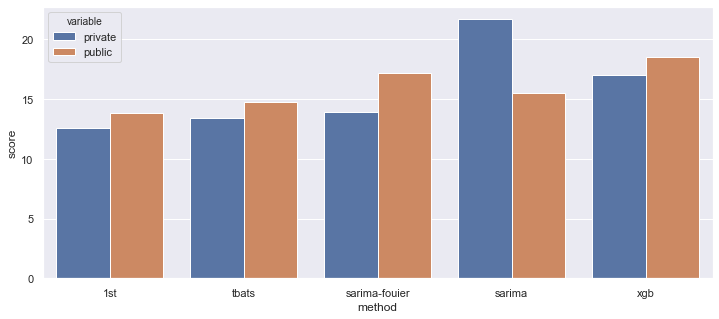

In [51]:
sns.set(rc={'figure.figsize':(12, 5)})
g = sns.barplot(data=score_df, x='method', y='score', hue='variable')
g.get_figure().savefig('plots/evaluation.jpg')
del g